In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

pd.set_option('max_columns', 100)

%matplotlib inline

Using TensorFlow backend.


In [2]:
COLS_SCOUTS = ['CA', 'FC', 'FS', 'GC', 'I', 'PE', 
               'RB', 'SG', 'FF', 'FD', 'G', 'DD', 
               'GS', 'A', 'FT', 'CV', 'DP', 'PP']

COL_ANSWER = ['variacao_preco']
COLS_FEATURES = ['pontos', 'preco', 'media_pontos'] + COLS_SCOUTS
COLS_EXTRA = ['id', 'rodada']
COLS_OF_INTEREST = COLS_EXTRA + COLS_FEATURES + COL_ANSWER

In [3]:
df = pd.read_csv('../../data/desafio_valorizacao/valorizacao_cartola_2018.csv')
print(df.shape)

df.head()

(30955, 33)


,n,nome_completo,slug,apelido,foto,id,rodada,id_time,posicao,status,pontos,preco,variacao_preco,media_pontos,nome_time,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP
0,7,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,38,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,37,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,36,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,35,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,34,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[COLS_OF_INTEREST]
print(df.shape)

df.head()

(30955, 24)


,id,rodada,pontos,preco,media_pontos,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP,variacao_preco
0,36540,38,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,36540,37,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,36540,36,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,36540,35,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,36540,34,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [5]:
df.isna().any()

id                False
rodada            False
pontos            False
preco             False
media_pontos      False
CA                 True
FC                 True
FS                 True
GC                 True
I                  True
PE                 True
RB                 True
SG                 True
FF                 True
FD                 True
G                  True
DD                 True
GS                 True
A                  True
FT                 True
CV                 True
DP                 True
PP                 True
variacao_preco    False
dtype: bool

In [6]:
df = df.fillna(value=0)

### Ajeita scouts cumulativos

In [7]:
def get_scouts_for_round(df, round_):
    suffixes = ('_curr', '_prev')
    cols_current = [col + suffixes[0] for col in COLS_SCOUTS]
    cols_prev = [col + suffixes[1] for col in COLS_SCOUTS]
    
    df_round = df[df.rodada == round_]
    if round_ == 1: return df_round
    
    df_round_prev = df[df.rodada < round_].groupby('id')[COLS_SCOUTS].max()
    df_players = df_round.merge(df_round_prev, how='left', on='id', suffixes=suffixes)
    
    # if is the first round of a player, the scouts of previous rounds will be NaNs. Thus, set them to zero
    df_players.fillna(value=0, inplace=True)
    
    # compute the scouts 
    df_players[cols_current] = df_players[cols_current].values - df_players[cols_prev].values
    
    # update the columns
    df_players.drop(labels=cols_prev, axis=1, inplace=True)
    df_players = df_players.rename(columns=dict(zip(cols_current, COLS_SCOUTS)))
    df_players.SG = df_players.SG.clip(lower=0)
    
    return df_players

In [8]:
# DONT RUN THIS CELL TWICE
df_clean = pd.DataFrame([])

for i in range(1, 39):
    df_round = get_scouts_for_round(df, i)
    print("Dimensões da rodada #{0}: {1}".format(i, df_round.shape))
    df_clean = df_clean.append(df_round, ignore_index=True)
    
df = df_clean.copy()

Dimensões da rodada #1: (789, 24)
Dimensões da rodada #2: (790, 24)
Dimensões da rodada #3: (797, 24)
Dimensões da rodada #4: (794, 24)
Dimensões da rodada #5: (793, 24)
Dimensões da rodada #6: (795, 24)
Dimensões da rodada #7: (792, 24)
Dimensões da rodada #8: (792, 24)
Dimensões da rodada #9: (799, 24)
Dimensões da rodada #10: (796, 24)
Dimensões da rodada #11: (794, 24)
Dimensões da rodada #12: (782, 24)
Dimensões da rodada #13: (791, 24)
Dimensões da rodada #14: (794, 24)
Dimensões da rodada #15: (799, 24)
Dimensões da rodada #16: (803, 24)
Dimensões da rodada #17: (813, 24)
Dimensões da rodada #18: (815, 24)
Dimensões da rodada #19: (811, 24)
Dimensões da rodada #20: (814, 24)
Dimensões da rodada #21: (810, 24)
Dimensões da rodada #22: (813, 24)
Dimensões da rodada #23: (824, 24)
Dimensões da rodada #24: (820, 24)
Dimensões da rodada #25: (822, 24)
Dimensões da rodada #26: (832, 24)
Dimensões da rodada #27: (832, 24)
Dimensões da rodada #28: (834, 24)
Dimensões da rodada #29: (835

### Cria dataframe de amostras

In [10]:
%%time
df_samples = pd.DataFrame([])

for rodada in range(1, 38):
    df_rod_atual = df[df.rodada == rodada]
    df_rod_prox = df[df.rodada == (rodada + 1)]
    df_merge = df_rod_atual.merge(df_rod_prox[['id', 'variacao_preco']] , how='left', on='id', suffixes=('_atual', '_prox'))
    df_merge = df_merge.dropna()
    df_merge = df_merge[df_merge.variacao_preco_prox > 0]
    df_samples = df_samples.append(df_merge)
    
print(df_samples.shape)

(5100, 25)
CPU times: user 338 ms, sys: 10 ms, total: 348 ms
Wall time: 346 ms


In [11]:
df_samples.head(10)

,id,rodada,pontos,preco,media_pontos,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP,variacao_preco_atual,variacao_preco_prox
2,37245,1,2.48,6.53,2.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.47,1.14
5,37319,1,1.19,2.20,1.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,2.27
11,37657,1,0.00,7.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.46
15,37694,1,6.80,11.57,6.80,0.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.57,0.34
16,37701,1,9.20,9.78,9.20,0.0,1.0,4.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.78,1.80
34,38279,1,7.30,11.23,7.30,1.0,5.0,0.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.23,2.19
52,38910,1,-1.00,2.76,-1.00,0.0,3.0,1.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.24,4.89
58,40006,1,3.61,10.06,3.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.94,0.33
65,42234,1,0.70,9.44,0.70,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-3.56,2.04
67,42500,1,0.50,12.06,0.50,0.0,0.0,1.0,0.0,0.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.94,2.05


# Training

In [12]:
x = df_samples.drop(columns=COLS_EXTRA + ['variacao_preco_prox']).values
y = df_samples['variacao_preco_prox'].values.reshape(-1, 1)

print(x.shape, y.shape)

(5100, 22) (5100, 1)


In [13]:
std = StandardScaler()
x = std.fit_transform(x)

In [14]:
reg = LinearRegression()
reg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

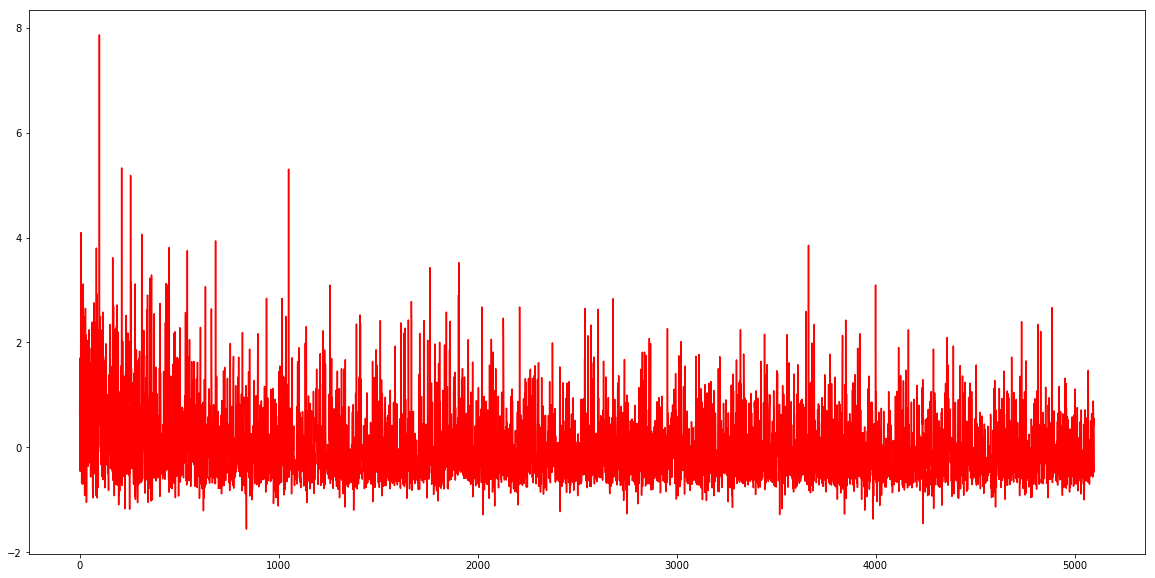

In [15]:
y_pred = reg.predict(x)
diff = y - y_pred

plt.figure(figsize=(20, 10))
plt.plot(diff, color='red')

In [16]:
diff.mean(), diff.std()

(6.687461042448001e-17, 0.7347136910856716)

In [17]:
print(reg.coef_)
print(reg.intercept_)

[[-0.21838617  0.04472851  0.02476218 -0.02368974 -0.00796417  0.05500673
  -0.02041345 -0.0085492  -0.01443317  0.10130991  0.070634    0.03247496
   0.0732016   0.10327032  0.07639538  0.03909548  0.06682013  0.01916744
   0.00781694 -0.01093197  0.00298263 -0.00506172]]
[0.79479412]
